# Лабораторная работа 6. Деревья решений

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Задание 1. Реализовать критерии выбора разбиений.
Необходимо реализовать два критерия выбора разбиений – прироста информации и индекс Джини – и протестировать их на примере датасета из лекции "Состоится ли игра?".

**Задание 1.1.** Создайте датасет "Состоится ли игра?" (вручную или прочитайте из файла):

In [208]:
df = pd.read_csv('../data/is_there_a_game.csv')
df

,Наблюдение,Температура,Влажность,Ветер,Игра
0,Солнце,Жарко,Высокая,Нет,Нет
1,Солнце,Жарко,Высокая,Есть,Нет
2,Облачность,Жарко,Высокая,Нет,Да
3,Дождь,Норма,Высокая,Нет,Да
4,Дождь,Холодно,Норма,Нет,Да
5,Дождь,Холодно,Норма,Есть,Нет
6,Облачность,Холодно,Норма,Есть,Да
7,Солнце,Норма,Высокая,Нет,Нет
8,Солнце,Холодно,Норма,Нет,Да
9,Дождь,Норма,Норма,Нет,Да


**Задание 1.2.** Напишите и протестируйте на примере датасета "Состоится ли игра?" функцию вычисления энтропии (`entropy`):

In [209]:
def entropy(labels):
    counts = labels.value_counts()
    probs = counts / len(labels)
    return -sum(probs * np.log2(probs + 1e-10))  # +1e-10 чтобы избежать log(0)


In [210]:
print(f'энтропия для "{df.columns[4]}": {entropy(df[df.columns[4]])}')

энтропия для "Игра": 0.9402859583820921


**Задание 1.3.** Напишите и протестируйте на примере датасета "Состоится ли игра?" функцию  прироста информации (`information_gain`) с использованием функции `entropy`:

In [211]:
def split_data(df, feature):
    return {value: df[df[feature] == value] for value in df[feature].unique()}

def information_gain(df, feature, target='Target'):
    total_entropy = entropy(df[target])
    splits = split_data(df, feature)
    weighted_entropy = 0.0
    for subset in splits.values():
        prob = len(subset) / len(df)
        weighted_entropy += prob * entropy(subset[target])
    
    return total_entropy - weighted_entropy

In [212]:
for i in range(len(df.columns) - 1):   
    print(f'gain {df.columns[i]} : {information_gain(df, df.columns[i], df.columns[4]):.3f}')

gain Наблюдение : 0.247
gain Температура : 0.029
gain Влажность : 0.152
gain Ветер : 0.048


**Задание 1.4.** Напишите и протестируйте на примере датасета "Состоится ли игра?" функцию вычисления индекса Джини (`gini`):

In [213]:
import numpy as np

def gini(labels: pd.Series):
    probabilities = labels.value_counts(normalize=True).values
    return 1 - np.sum(probabilities ** 2)

In [214]:
for i in range(len(df.columns) - 1): 
    print(f'gini {df.columns[i]} : {gini(df[df.columns[i]]):.3f}')

gini Наблюдение : 0.663
gini Температура : 0.653
gini Влажность : 0.500
gini Ветер : 0.490


### Задание 2. Постройте дерево решений (факультативно)

**Задание 2.1.** Для датасета "Состоится ли игра?" постройте дерево решений на основе функции `information_gain`.

In [215]:
def build_decision_tree(df, target='Target', parent_mode=None):
    current_target = df[target]
    current_mode = current_target.mode()[0]
    
    if len(current_target.unique()) == 1:
        return current_target.iloc[0]
    if df.shape[1] == 1:
        return current_mode
    
    features = df.columns.drop(target)
    gains = {feature: information_gain(df, feature, target) for feature in features}
    best_feature = max(gains, key=gains.get)
    
    tree = {best_feature: {}}
    splits = split_data(df, best_feature)
    
    for value, subset in splits.items():
        if subset.empty:
            subtree = parent_mode if parent_mode is not None else current_mode
        else:
            subtree_df = subset.drop(columns=[best_feature])
            subtree = build_decision_tree(subtree_df, target, current_mode)
        tree[best_feature][value] = subtree
    
    return tree


In [216]:
tree = build_decision_tree(df, target='Игра')

**Задание 2.2.** Визуализируйте построенное дерево (в любом виде):

In [217]:
import json

print(json.dumps(tree, indent=4, ensure_ascii=False))

{
    "Наблюдение": {
        "Солнце": {
            "Влажность": {
                "Высокая": "Нет",
                "Норма": "Да"
            }
        },
        "Облачность": "Да",
        "Дождь": {
            "Ветер": {
                "Нет": "Да",
                "Есть": "Нет"
            }
        }
    }
}


**Задание 2.3.** Сравните полученные результаты с результатами функции из `scikit-learn`:

[Text(0.6, 0.9, 'Влажность <= 0.5\nentropy = 0.94\nsamples = 14\nvalue = [9, 5]\nclass = No'),
 Text(0.4, 0.7, 'Наблюдение <= 1.5\nentropy = 0.985\nsamples = 7\nvalue = [3, 4]\nclass = Yes'),
 Text(0.5, 0.8, 'True  '),
 Text(0.3, 0.5, 'Ветер <= 0.5\nentropy = 0.811\nsamples = 4\nvalue = [3, 1]\nclass = No'),
 Text(0.2, 0.3, 'Наблюдение <= 0.5\nentropy = 1.0\nsamples = 2\nvalue = [1, 1]\nclass = No'),
 Text(0.1, 0.1, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = Yes'),
 Text(0.3, 0.1, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = No'),
 Text(0.4, 0.3, 'entropy = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = No'),
 Text(0.5, 0.5, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]\nclass = Yes'),
 Text(0.8, 0.7, 'Ветер <= 0.5\nentropy = 0.592\nsamples = 7\nvalue = [6, 1]\nclass = No'),
 Text(0.7, 0.8, '  False'),
 Text(0.7, 0.5, 'Наблюдение <= 0.5\nentropy = 0.918\nsamples = 3\nvalue = [2, 1]\nclass = No'),
 Text(0.6, 0.3, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = Yes'),
 Te

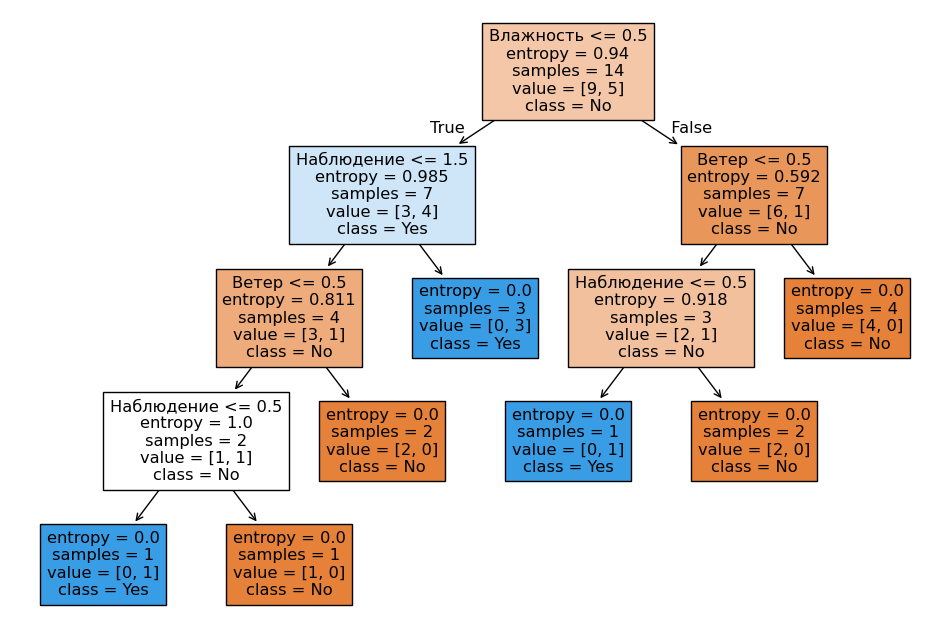

In [219]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()

le = LabelEncoder()
for col in df_encoded.columns:
    df_encoded[col] = le.fit_transform(df_encoded[col])

X = df_encoded.drop('Игра', axis=1)
y = df_encoded['Игра']

from sklearn.tree import DecisionTreeClassifier, plot_tree

clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf.fit(X, y)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=X.columns, class_names=['No', 'Yes'], filled=True)